In [1]:
!pip install sklearn
!pip install -U jina
!pip install -U --pre finetuner

# Load Swiss Roll Dataset

In [2]:
# Generate data (swiss roll dataset)
from sklearn.datasets import make_swiss_roll
n_samples = 1500
noise = 0.05
X, y = make_swiss_roll(n_samples, noise=noise)

In [3]:
def minmax_norm(y):
    return (y-y.min())/(y.max()-y.min())

/tmp/ipykernel_30324/1794200084.py:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)


[Text(-15.0, 0, ''),
 Text(-10.0, 0, ''),
 Text(-5.0, 0, ''),
 Text(0.0, 0, ''),
 Text(5.0, 0, ''),
 Text(10.0, 0, ''),
 Text(15.0, 0, ''),
 Text(20.0, 0, '')]

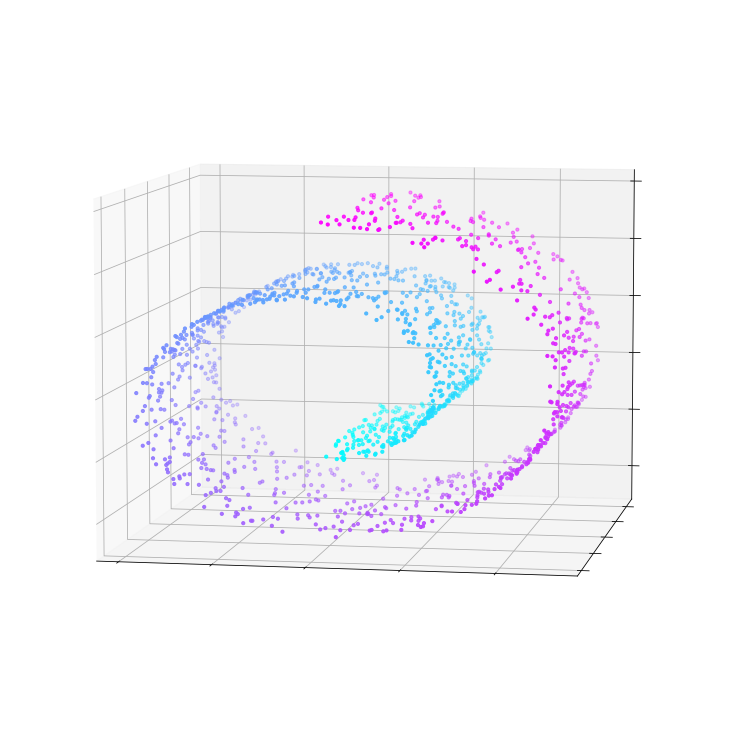

In [4]:
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 10))
ax = p3.Axes3D(fig)
ax.view_init(7, -80)

ax.scatter(
        X[:,0],
        X[:,1],
        X[:,2],
        color=plt.cm.cool(minmax_norm(y)),
        s=10)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

# Some plot helper function

In [5]:
def plot_scatter(_da, idx, limit, fig=None, pos=None, title=None):
    q = _da[idx]
    
    if title == 'groundtruth':
        metric = 'euclidean'
    else:
        metric = 'cosine'
        
    q.match(_da, limit=None, normalize=(1, 0), metric=metric)
    scores = q.matches.get_attributes(f'scores__{metric}__value')
    
    if fig is None:
        fig = plt.figure(figsize=(10, 10))
        ax = p3.Axes3D(fig)
    else:
        ax = fig.add_subplot(*pos, projection='3d')
        
    ax.view_init(7, -80)
    

    X_q = q.matches.blobs
    
    # all points
    ax.scatter(
            X_q[:,0],
            X_q[:,1],
            X_q[:,2],
            color='w',
            s=10,
            alpha=0.2
        )

    # nearest neighbours
    ax.scatter(
            X_q[:limit,0],
            X_q[:limit,1],
            X_q[:limit,2],
            color=plt.cm.cool(scores[:limit]),
            s=10,
    )
    
    # the query point
    ax.scatter(
            q.blob[0],
            q.blob[1],
            q.blob[2],
            color='r',
            edgecolor='r',
            s=50,
        )
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    
    if title:
        ax.title.set_text(title)
    q.matches.clear()

# Before finetuning: Find 1000 NN in original space

In [6]:
from jina import DocumentArray
import numpy as np

da = DocumentArray.empty(len(X))
da.blobs = X.astype(np.float32)
da.embeddings = X.astype(np.float32)

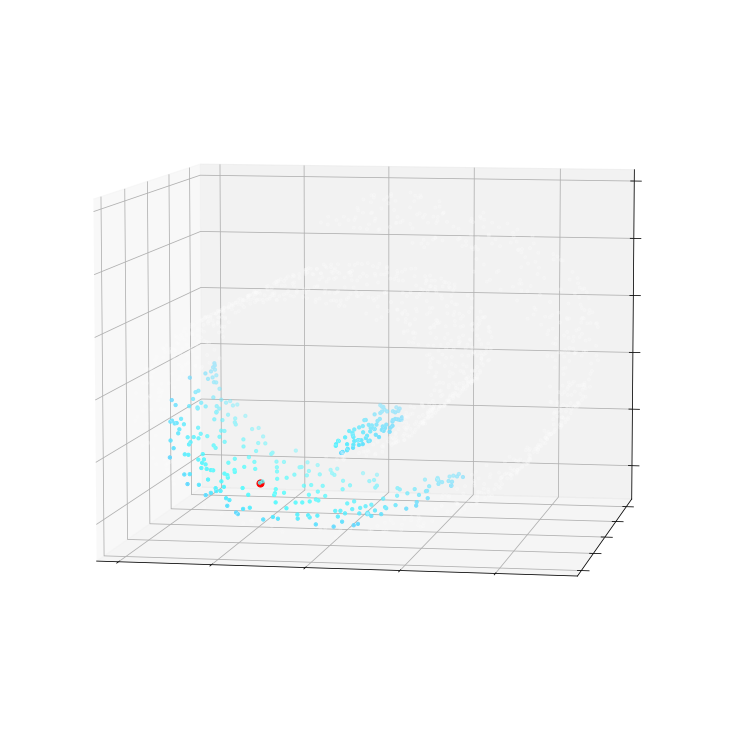

In [18]:
plot_scatter(da, 3, 300)

# Construct finetuning labels by following the rolls

Make 5 labels

In [8]:
bins = np.linspace(0, 1, 5)
label_y = np.digitize(minmax_norm(X[:,1]), bins)

Visualize the labels.

Points with same label are considered as nearest neighbours. 

And this will be our training data.

[Text(-15.0, 0, ''),
 Text(-10.0, 0, ''),
 Text(-5.0, 0, ''),
 Text(0.0, 0, ''),
 Text(5.0, 0, ''),
 Text(10.0, 0, ''),
 Text(15.0, 0, ''),
 Text(20.0, 0, '')]

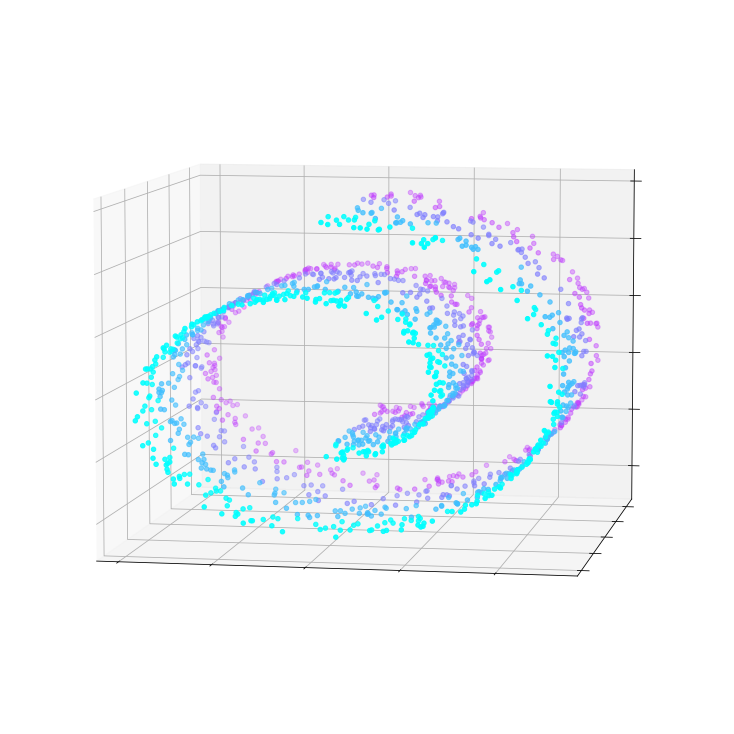

In [9]:
fig = plt.figure(figsize=(10, 10))
ax = p3.Axes3D(fig)
ax.view_init(7, -80)

ax.scatter(
        X[:,0],
        X[:,1],
        X[:,2],
        color=plt.cm.cool(minmax_norm(label_y)),
        s=20,
    )
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

# Call Finetuner

In [10]:
for d, l_y in zip(da, label_y):
    d.tags['finetuner_label'] = int(l_y)

In [11]:
import torch

D = 6
embed_model = lambda: torch.nn.Sequential(
            torch.nn.Linear(in_features=3, out_features=D),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=D, out_features=D),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=D, out_features=D))

In [12]:
import finetuner

In [13]:
new_model, summary = finetuner.fit(embed_model(), train_data=da, epochs=500)

⠙ Epoch 1/500 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 0:00:00 estimating... 

⠴       DONE ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 0:00:00 100% ETA: 0 seconds Train Loss: 0.73Train Loss: 0.73Train Loss: 0.73Train Loss: 0.73Train Loss: 0.73Train Loss: 0.73Train Loss: 0.73Train Loss: 0.72Train Loss: 0.70Train Loss: 0.71Train Loss: 0.73Train Loss: 0.71Train Loss: 0.72Train Loss: 0.68Train Loss: 0.71Train Loss: 0.70Train Loss: 0.71Train Loss: 0.70Train Loss: 0.70Train Loss: 0.68Train Loss: 0.69Train Loss: 0.68Train Loss: 0.69Train Loss: 0.67Train Loss: 0.67Train Loss: 0.67Train Loss: 0.67Train Loss: 0.65Train Loss: 0.66Train Loss: 0.65Train Loss: 0.65Train Loss: 0.64Train Loss: 0.64Train Loss: 0.64Train Loss: 0.62Train Loss: 0.63Train Loss: 0.64Train Loss: 0.61Train Loss: 0.63Train Loss: 0.63Train Loss: 0.62Train Loss: 0.61Train Loss: 0.60Train Loss: 0.60Train Loss: 0.60Train Loss: 0.57Train Loss: 0.58Train Loss: 0.58Train Loss: 0.58Train Loss: 0.56Train Loss: 0.56Train Loss: 0.56Train Loss: 0.54Train Loss: 0.54Train Loss: 0.54Train Loss: 0.55Train Loss: 0.52Train

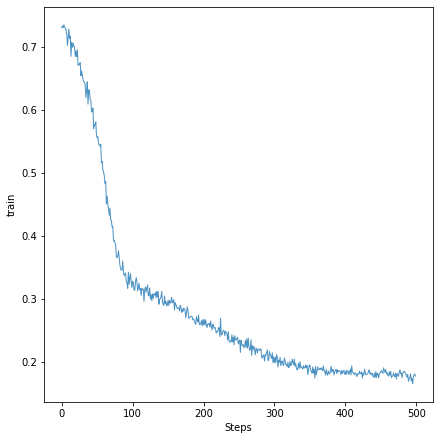

In [14]:
summary.plot()

# Validate results

Let's compare the NN search results on orignal space, the random model projected space, the finetuned space and the groundtruth space,

In [15]:
rand_model = embed_model()
from copy import deepcopy

da2 = deepcopy(da)
da3 = deepcopy(da)
da4 = deepcopy(da)
finetuner.embed(da2,  rand_model)
finetuner.embed(da3, new_model)
da4.embeddings = np.expand_dims(label_y, axis=1).astype(np.float32)

In [16]:
def plot_helper2(idx, limit=None):
    fig = plt.figure(figsize=(20, 20), constrained_layout=True)
    plot_scatter(da, idx, limit, fig, (1, 4, 1), title='original')
    plot_scatter(da2, idx, limit, fig, (1, 4, 2), title='random init')
    plot_scatter(da3, idx, limit, fig, (1, 4, 3), title='finetuned')
    plot_scatter(da4, idx, limit, fig, (1, 4, 4), title='groundtruth')

Sample some random points to plot

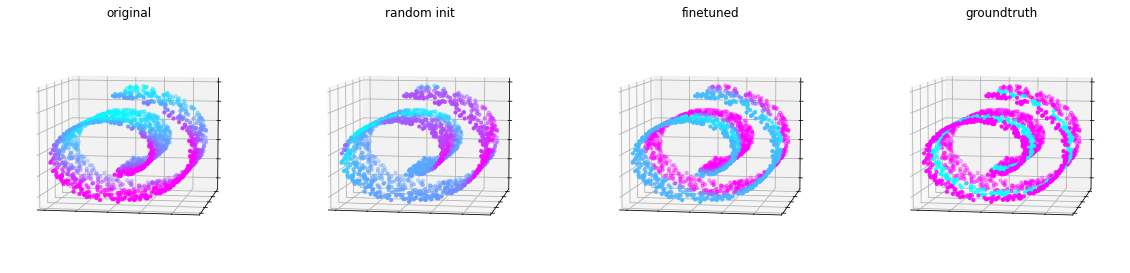

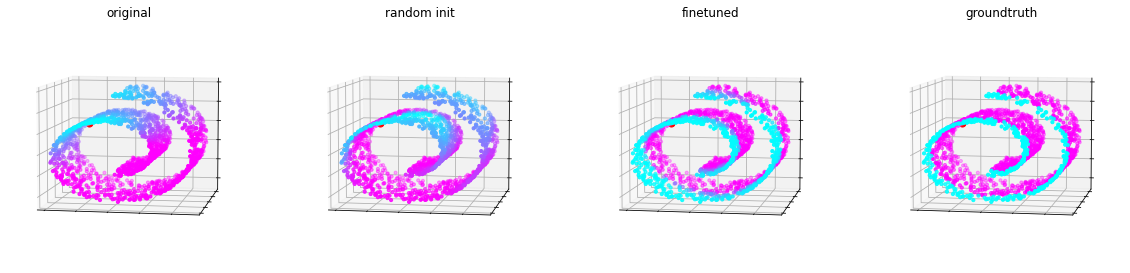

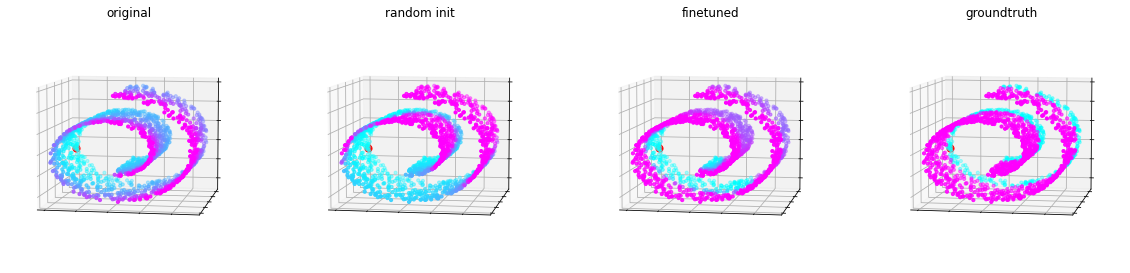

In [ ]:
from random import randint

for _ in range(4):
    plot_helper2(randint(0, len(da)))